In [11]:
import pandas as pd

df = pd.read_excel("S:/Pizza/dataset/Pizza_Sale.xlsx")


In [12]:
sales_df = df.copy()

In [13]:
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])

In [14]:
sales_df.set_index('order_date',inplace=True)

In [15]:
sales_df['Weekly_sales'] = sales_df.quantity.resample('W').sum()

In [16]:
sales_df.reset_index(inplace=True)

In [17]:
columns_to_keep = ['order_date', 'pizza_name_id', 'quantity','Weekly_sales']

In [18]:
sales_df = sales_df[columns_to_keep]

In [24]:
sales_df['Week'] = sales_df['order_date'].dt.isocalendar().week
sales_df['year'] = sales_df['order_date'].dt.year

In [40]:
weekly_sales_df = sales_df.groupby(['pizza_name_id','order_date','Week']).agg({'quantity':'sum'}).reset_index()
weekly_sales_df

,pizza_name_id,order_date,Week,quantity
0,bbq_ckn_l,2015-01-01,1,6
1,bbq_ckn_l,2015-01-02,1,4
2,bbq_ckn_l,2015-01-03,1,2
3,bbq_ckn_l,2015-01-05,2,2
4,bbq_ckn_l,2015-01-06,2,1
...,...,...,...,...
22955,veggie_veg_s,2015-12-24,52,1
22956,veggie_veg_s,2015-12-27,52,3
22957,veggie_veg_s,2015-12-28,53,1
22958,veggie_veg_s,2015-12-30,53,4


In [30]:
weekly_sales_df.pizza_name_id.value_counts().sort_values(ascending=True).head(10)

pizza_name_id
the_greek_xxl     22
calabrese_s       43
ckn_alfredo_s     44
green_garden_l    46
mexicana_s        49
ital_veggie_l     51
mediterraneo_s    51
prsc_argla_l      52
ckn_alfredo_l     52
spinach_supr_m    52
Name: count, dtype: int64

In [42]:
#day of the week

weekly_sales_df['Day'] = weekly_sales_df['order_date'].dt.day_name()

In [45]:
#holiday in 2015
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

holiday = calendar().holidays(start='2015-01-01', end='2015-12-31')
weekly_sales_df['Holiday'] = weekly_sales_df['order_date'].isin(holiday)

In [47]:
#weekend 

weekly_sales_df['Weekend'] = weekly_sales_df['Day'].isin(['Saturday','Sunday'])

In [52]:
weekly_sales_df[weekly_sales_df['pizza_name_id'] == 'ckn_alfredo_s']['Weekend'].value_counts()

Weekend
False    64
True     20
Name: count, dtype: int64

<Axes: xlabel='Week'>

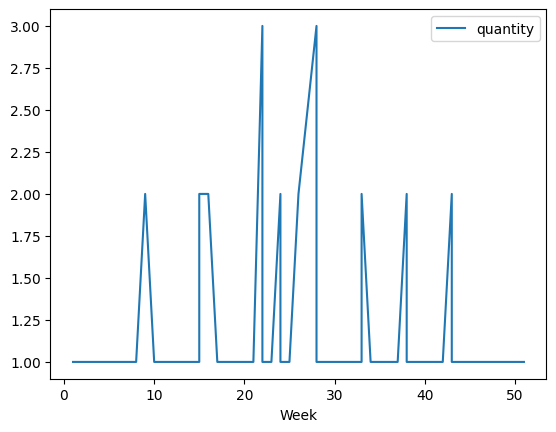

In [55]:
weekly_sales_df[weekly_sales_df['pizza_name_id'] == 'ckn_alfredo_s'][['Week','quantity']].plot(kind='line',x='Week',y='quantity')

In [60]:
weekly_sales_df.set_index('order_date',inplace=True)

In [61]:
#grouping the pizza names in a list to iterate through it later on 
pizza_name_df = []
pizza_name_list = weekly_sales_df.pizza_name_id.unique().tolist()
for pizza_name in pizza_name_list:
    globals()[f'{pizza_name}_df'] = weekly_sales_df[weekly_sales_df['pizza_name_id'] == pizza_name]
    pizza_name_df.append([f'{pizza_name}_df'])
pizza_name_df

[['bbq_ckn_l_df'],
 ['bbq_ckn_m_df'],
 ['bbq_ckn_s_df'],
 ['big_meat_s_df'],
 ['brie_carre_s_df'],
 ['calabrese_l_df'],
 ['calabrese_m_df'],
 ['calabrese_s_df'],
 ['cali_ckn_l_df'],
 ['cali_ckn_m_df'],
 ['cali_ckn_s_df'],
 ['ckn_alfredo_l_df'],
 ['ckn_alfredo_m_df'],
 ['ckn_alfredo_s_df'],
 ['ckn_pesto_l_df'],
 ['ckn_pesto_m_df'],
 ['ckn_pesto_s_df'],
 ['classic_dlx_l_df'],
 ['classic_dlx_m_df'],
 ['classic_dlx_s_df'],
 ['five_cheese_l_df'],
 ['four_cheese_l_df'],
 ['four_cheese_m_df'],
 ['green_garden_l_df'],
 ['green_garden_m_df'],
 ['green_garden_s_df'],
 ['hawaiian_l_df'],
 ['hawaiian_m_df'],
 ['hawaiian_s_df'],
 ['ital_cpcllo_l_df'],
 ['ital_cpcllo_m_df'],
 ['ital_cpcllo_s_df'],
 ['ital_supr_l_df'],
 ['ital_supr_m_df'],
 ['ital_supr_s_df'],
 ['ital_veggie_l_df'],
 ['ital_veggie_m_df'],
 ['ital_veggie_s_df'],
 ['mediterraneo_l_df'],
 ['mediterraneo_m_df'],
 ['mediterraneo_s_df'],
 ['mexicana_l_df'],
 ['mexicana_m_df'],
 ['mexicana_s_df'],
 ['napolitana_l_df'],
 ['napolitana_m_df'],

In [62]:
bbq_ckn_l_df.sample(2)

,pizza_name_id,Week,quantity,Day,Holiday,Weekend
order_date,,,,,,
2015-09-05,bbq_ckn_l,36,3,Saturday,False,True
2015-06-05,bbq_ckn_l,23,2,Friday,False,False


In [65]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def create_features(df):
    df.loc[:, 'month'] = df.index.month
    df.loc[:, 'year'] = df.index.year
    df.loc[:, 'weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['weekly_sales'].to_dict()
    df.loc[:, 'lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df.loc[:, 'lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df.loc[:, 'lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

def feature_engineering(df):
    df = create_features(df)
    df = add_lags(df)
    return df

def sales_feature(df):
    df = df.copy()  # Ensure df is a copy to avoid SettingWithCopyWarning
    df.set_index('order_date', inplace=True)
    df.loc[:, 'weekly_sales'] = df['quantity'].resample('W').sum()
    df.drop(columns=['pizza_name_id', 'quantity'], inplace=True)
    df = feature_engineering(df)
    return df

def model_training(df):
    if df.empty:
        raise ValueError("DataFrame is empty after preprocessing.")
    
    tss = TimeSeriesSplit(n_splits=3, test_size=4, gap=0)
    preds = []
    scores = []

    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        FEATURES = ['weekofyear', 'month', 'year', 'lag1', 'lag2', 'lag3']
        TARGET = 'weekly_sales'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               n_estimators=400, early_stopping_rounds=50,
                               objective='reg:linear', max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
    
    future = pd.date_range(start=df.index.max() + pd.Timedelta('7 days'), 
                           periods=4, freq='W')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = feature_engineering(df_and_future)
    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    predicted_sum = future_w_features['pred'].sum()
    return predicted_sum

In [66]:
# Loop through each pizza_name_id
pizza_name_list = sales_df.pizza_name_id.unique().tolist()

def pizza_df(df, pizza_name):
    return df[df['pizza_name_id'] == pizza_name]

# Dictionary to store the results
results_dict = {}

# Loop through each pizza_name_id, process the data, and save the results
for pizza_name in pizza_name_list:
    print(f"Processing {pizza_name}...")
    df = pizza_df(sales_df, pizza_name)
    if not df.empty:  # Check if df is not empty
        df = sales_feature(df)
        try:
            predicted_sum = model_training(df)
            results_dict[pizza_name] = predicted_sum
        except ValueError as e:
            print(f"Skipping {pizza_name} due to error: {e}")
    else:
        print(f"No data for {pizza_name}, skipping...")

# Print results
for name, predictions in results_dict.items():
    print(f"Predicted total sales for {name} for next 4 weeks: {predictions}")

Processing hawaiian_m...
Skipping hawaiian_m due to error: [08:05:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.
Processing classic_dlx_m...
Skipping classic_dlx_m due to error: [08:05:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.
Processing five_cheese_l...
Skipping five_cheese_l due to error: [08:05:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.
Processing ital_supr_l...
Skipping ital_supr_l due to error: [08:05:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6

In [67]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def create_features(df):
    df.loc[:, 'month'] = df.index.month
    df.loc[:, 'year'] = df.index.year
    df.loc[:, 'weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['weekly_sales'].to_dict()
    df.loc[:, 'lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df.loc[:, 'lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df.loc[:, 'lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

def feature_engineering(df):
    df = create_features(df)
    df = add_lags(df)
    df.fillna(0, inplace=True)  # Fill NaNs in feature columns with 0
    return df

def sales_feature(df):
    df = df.copy()  # Ensure df is a copy to avoid SettingWithCopyWarning
    df.set_index('order_date', inplace=True)
    df.loc[:, 'weekly_sales'] = df['quantity'].resample('W').sum()
    df.drop(columns=['pizza_name_id', 'quantity'], inplace=True)
    df = feature_engineering(df)
    return df

def model_training(df):
    if df.empty:
        raise ValueError("DataFrame is empty after preprocessing.")
    
    tss = TimeSeriesSplit(n_splits=3, test_size=4, gap=0)
    preds = []
    scores = []

    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        FEATURES = ['weekofyear', 'month', 'year', 'lag1', 'lag2', 'lag3']
        TARGET = 'weekly_sales'

        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]

        if y_train.isna().any() or y_test.isna().any():
            raise ValueError("Target variable contains NaN values after preprocessing.")

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               n_estimators=400, early_stopping_rounds=50,
                               objective='reg:linear', max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
    
    future = pd.date_range(start=df.index.max() + pd.Timedelta('7 days'), 
                           periods=4, freq='W')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = feature_engineering(df_and_future)
    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    predicted_sum = future_w_features['pred'].sum()
    return predicted_sum

# Assume sales_df is the DataFrame containing the sales data
# Loop through each pizza_name_id
pizza_name_list = sales_df.pizza_name_id.unique().tolist()

def pizza_df(df, pizza_name):
    return df[df['pizza_name_id'] == pizza_name]

# Dictionary to store the results
results_dict = {}

# Loop through each pizza_name_id, process the data, and save the results
for pizza_name in pizza_name_list:
    print(f"Processing {pizza_name}...")
    df = pizza_df(sales_df, pizza_name)
    if not df.empty:  # Check if df is not empty
        df = sales_feature(df)
        try:
            predicted_sum = model_training(df)
            results_dict[pizza_name] = predicted_sum
        except ValueError as e:
            print(f"Skipping {pizza_name} due to error: {e}")
    else:
        print(f"No data for {pizza_name}, skipping...")

# Print results
for name, predictions in results_dict.items():
    print(f"Predicted total sales for {name} for next 4 weeks: {predictions}")


Processing hawaiian_m...
[0]	validation_0-rmse:3.58035	validation_1-rmse:3.25444
[100]	validation_0-rmse:1.67560	validation_1-rmse:1.41748
[200]	validation_0-rmse:1.03694	validation_1-rmse:0.48903


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.85632	validation_1-rmse:0.27540
[398]	validation_0-rmse:0.79850	validation_1-rmse:0.26361
[0]	validation_0-rmse:3.57762	validation_1-rmse:0.49573
[100]	validation_0-rmse:1.67231	validation_1-rmse:0.23078


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.03410	validation_1-rmse:0.13354
[300]	validation_0-rmse:0.85236	validation_1-rmse:0.08600
[399]	validation_0-rmse:0.79421	validation_1-rmse:0.06135
[0]	validation_0-rmse:3.56263	validation_1-rmse:3.72417
[100]	validation_0-rmse:1.66526	validation_1-rmse:0.33518
[171]	validation_0-rmse:1.14136	validation_1-rmse:0.49885


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing classic_dlx_m...
[0]	validation_0-rmse:8.23264	validation_1-rmse:15.75446
[100]	validation_0-rmse:3.35838	validation_1-rmse:5.62488


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.69781	validation_1-rmse:2.07120
[300]	validation_0-rmse:1.22784	validation_1-rmse:0.72783
[399]	validation_0-rmse:1.07909	validation_1-rmse:0.16181
[0]	validation_0-rmse:8.27063	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.37070	validation_1-rmse:0.18137
[200]	validation_0-rmse:1.70051	validation_1-rmse:0.06646


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.22778	validation_1-rmse:0.02435
[399]	validation_0-rmse:1.07719	validation_1-rmse:0.01655
[0]	validation_0-rmse:8.25635	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.36488	validation_1-rmse:0.18137


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.69757	validation_1-rmse:0.06646
[300]	validation_0-rmse:1.22565	validation_1-rmse:0.02435
[399]	validation_0-rmse:1.07533	validation_1-rmse:0.01652
Processing five_cheese_l...
[0]	validation_0-rmse:9.94328	validation_1-rmse:8.13248
[100]	validation_0-rmse:4.24316	validation_1-rmse:2.44947


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.41041	validation_1-rmse:0.75493
[300]	validation_0-rmse:1.86308	validation_1-rmse:0.04590
[354]	validation_0-rmse:1.74518	validation_1-rmse:0.49351
[0]	validation_0-rmse:9.93857	validation_1-rmse:0.49500
[100]	validation_0-rmse:4.24140	validation_1-rmse:0.18284


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.40932	validation_1-rmse:0.07614
[300]	validation_0-rmse:1.85951	validation_1-rmse:0.03615
[399]	validation_0-rmse:1.67782	validation_1-rmse:0.01935
[0]	validation_0-rmse:9.92392	validation_1-rmse:0.49500
[100]	validation_0-rmse:4.23514	validation_1-rmse:0.18283


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.40472	validation_1-rmse:0.07591
[300]	validation_0-rmse:1.85676	validation_1-rmse:0.03611
[399]	validation_0-rmse:1.67534	validation_1-rmse:0.01931
Processing ital_supr_l...
[0]	validation_0-rmse:5.48966	validation_1-rmse:0.49616
[100]	validation_0-rmse:2.53660	validation_1-rmse:0.25499
[200]	validation_0-rmse:1.59390	validation_1-rmse:0.13660


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.32206	validation_1-rmse:0.08575
[399]	validation_0-rmse:0.99824	validation_1-rmse:0.05829
[0]	validation_0-rmse:5.47463	validation_1-rmse:3.21517
[100]	validation_0-rmse:2.52965	validation_1-rmse:0.57179
[134]	validation_0-rmse:2.07704	validation_1-rmse:1.35514
[0]	validation_0-rmse:5.46499	validation_1-rmse:0.49615


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.53199	validation_1-rmse:0.25417
[200]	validation_0-rmse:1.60578	validation_1-rmse:0.14188
[300]	validation_0-rmse:1.32712	validation_1-rmse:0.08412
[399]	validation_0-rmse:0.99717	validation_1-rmse:0.05857
Processing mexicana_m...
[0]	validation_0-rmse:3.79108	validation_1-rmse:3.23437
[100]	validation_0-rmse:1.73300	validation_1-rmse:1.66148
[200]	validation_0-rmse:0.97998	validation_1-rmse:1.05540


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.72070	validation_1-rmse:0.90301
[399]	validation_0-rmse:0.61985	validation_1-rmse:0.70336
[0]	validation_0-rmse:3.78655	validation_1-rmse:1.75929
[100]	validation_0-rmse:1.72737	validation_1-rmse:0.69078
[0]	validation_0-rmse:3.77342	validation_1-rmse:0.49527


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.72695	validation_1-rmse:0.19807
[200]	validation_0-rmse:0.99856	validation_1-rmse:0.08685
[300]	validation_0-rmse:0.74936	validation_1-rmse:0.04343
[399]	validation_0-rmse:0.65948	validation_1-rmse:0.02849
Processing thai_ckn_l...
[0]	validation_0-rmse:9.48365	validation_1-rmse:27.04606
[100]	validation_0-rmse:3.86466	validation_1-rmse:12.24285
[200]	validation_0-rmse:1.95031	validation_1-rmse:6.11295


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.37923	validation_1-rmse:4.13260
[399]	validation_0-rmse:1.09996	validation_1-rmse:3.49164
[0]	validation_0-rmse:9.58271	validation_1-rmse:0.49500
[100]	validation_0-rmse:3.90060	validation_1-rmse:0.18134
[200]	validation_0-rmse:1.97057	validation_1-rmse:0.06643


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.38397	validation_1-rmse:0.02434
[399]	validation_0-rmse:1.10522	validation_1-rmse:0.01791
[0]	validation_0-rmse:9.56863	validation_1-rmse:0.49500
[100]	validation_0-rmse:3.89487	validation_1-rmse:0.18134


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.96767	validation_1-rmse:0.06643
[300]	validation_0-rmse:1.38193	validation_1-rmse:0.02434
[399]	validation_0-rmse:1.10359	validation_1-rmse:0.01788
Processing ital_supr_m...
[0]	validation_0-rmse:6.62367	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.80784	validation_1-rmse:0.18142
[200]	validation_0-rmse:1.52674	validation_1-rmse:0.06675


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.11582	validation_1-rmse:0.02760
[399]	validation_0-rmse:0.92254	validation_1-rmse:0.01457
[0]	validation_0-rmse:6.60921	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.80170	validation_1-rmse:0.18142
[200]	validation_0-rmse:1.52340	validation_1-rmse:0.06675


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.11337	validation_1-rmse:0.02759
[399]	validation_0-rmse:0.92088	validation_1-rmse:0.01466
[0]	validation_0-rmse:6.59485	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.79560	validation_1-rmse:0.18142
[200]	validation_0-rmse:1.52007	validation_1-rmse:0.06674


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.11094	validation_1-rmse:0.02757
[399]	validation_0-rmse:0.91887	validation_1-rmse:0.01464
Processing prsc_argla_l...
[0]	validation_0-rmse:2.93678	validation_1-rmse:0.49614
[100]	validation_0-rmse:1.69954	validation_1-rmse:0.25356
[197]	validation_0-rmse:1.36012	validation_1-rmse:0.35018


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.92299	validation_1-rmse:7.38089
[100]	validation_0-rmse:1.69145	validation_1-rmse:3.90390
[200]	validation_0-rmse:1.34974	validation_1-rmse:2.70722


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.25091	validation_1-rmse:2.23901
[399]	validation_0-rmse:1.20229	validation_1-rmse:2.15654
[0]	validation_0-rmse:2.99666	validation_1-rmse:0.49612
[100]	validation_0-rmse:1.70837	validation_1-rmse:0.25241
[200]	validation_0-rmse:1.36029	validation_1-rmse:0.28636
[201]	validation_0-rmse:1.35866	validation_1-rmse:0.28581


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing bbq_ckn_s...
[0]	validation_0-rmse:3.40986	validation_1-rmse:3.23589
[100]	validation_0-rmse:1.78191	validation_1-rmse:0.48082
[188]	validation_0-rmse:1.34432	validation_1-rmse:0.36555


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:3.40852	validation_1-rmse:0.49626
[100]	validation_0-rmse:1.77903	validation_1-rmse:0.26111
[200]	validation_0-rmse:1.30938	validation_1-rmse:0.15577


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.17352	validation_1-rmse:0.10839
[387]	validation_0-rmse:1.13443	validation_1-rmse:0.11571
[0]	validation_0-rmse:3.39444	validation_1-rmse:0.49625
[100]	validation_0-rmse:1.77163	validation_1-rmse:0.26037


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.30374	validation_1-rmse:0.15493
[300]	validation_0-rmse:1.16886	validation_1-rmse:0.10740
[387]	validation_0-rmse:1.12997	validation_1-rmse:0.11395
Processing the_greek_s...
[0]	validation_0-rmse:2.13675	validation_1-rmse:1.77585
[100]	validation_0-rmse:1.19501	validation_1-rmse:0.54041


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.89340	validation_1-rmse:0.22391
[229]	validation_0-rmse:0.85132	validation_1-rmse:0.35421
[0]	validation_0-rmse:2.13236	validation_1-rmse:0.49597
[100]	validation_0-rmse:1.18633	validation_1-rmse:0.24283
[200]	validation_0-rmse:0.88799	validation_1-rmse:0.14116


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.78527	validation_1-rmse:0.09666
[399]	validation_0-rmse:0.75180	validation_1-rmse:0.08404
[0]	validation_0-rmse:2.11864	validation_1-rmse:4.57229
[100]	validation_0-rmse:1.17849	validation_1-rmse:2.80549
[200]	validation_0-rmse:0.88205	validation_1-rmse:1.57045


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.78038	validation_1-rmse:1.01030
[399]	validation_0-rmse:0.74624	validation_1-rmse:0.82924
Processing spinach_supr_s...
[0]	validation_0-rmse:3.36820	validation_1-rmse:0.49604
[100]	validation_0-rmse:1.64206	validation_1-rmse:0.24163
[200]	validation_0-rmse:1.09111	validation_1-rmse:0.14069


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.92617	validation_1-rmse:0.09150
[399]	validation_0-rmse:0.83982	validation_1-rmse:0.06478
[0]	validation_0-rmse:3.35103	validation_1-rmse:5.71890
[100]	validation_0-rmse:1.63363	validation_1-rmse:2.96050
[200]	validation_0-rmse:1.08547	validation_1-rmse:1.96808


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.92158	validation_1-rmse:1.64349
[335]	validation_0-rmse:0.89712	validation_1-rmse:1.64712
[0]	validation_0-rmse:3.38368	validation_1-rmse:0.82336
[67]	validation_0-rmse:2.02650	validation_1-rmse:1.47427


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing classic_dlx_s...
[0]	validation_0-rmse:5.15339	validation_1-rmse:7.34361


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.18171	validation_1-rmse:1.13053
[185]	validation_0-rmse:1.27330	validation_1-rmse:1.04887
[0]	validation_0-rmse:5.16715	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.19137	validation_1-rmse:0.18146


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.19006	validation_1-rmse:0.06895
[300]	validation_0-rmse:0.88600	validation_1-rmse:0.02618
[399]	validation_0-rmse:0.77808	validation_1-rmse:0.01241
[0]	validation_0-rmse:5.15404	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.18580	validation_1-rmse:0.18146
[200]	validation_0-rmse:1.18702	validation_1-rmse:0.06893


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.88405	validation_1-rmse:0.02616
[399]	validation_0-rmse:0.77601	validation_1-rmse:0.01236
Processing green_garden_s...
[0]	validation_0-rmse:4.24095	validation_1-rmse:0.49523
[100]	validation_0-rmse:1.96639	validation_1-rmse:0.20484


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.24121	validation_1-rmse:0.09381
[300]	validation_0-rmse:1.01093	validation_1-rmse:0.04671
[399]	validation_0-rmse:0.93468	validation_1-rmse:0.02530
[0]	validation_0-rmse:4.22660	validation_1-rmse:3.72155
[100]	validation_0-rmse:1.95970	validation_1-rmse:0.27622
[164]	validation_0-rmse:1.40453	validation_1-rmse:0.57135


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:4.22349	validation_1-rmse:0.49523
[100]	validation_0-rmse:1.95949	validation_1-rmse:0.20452


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.23723	validation_1-rmse:0.09344
[300]	validation_0-rmse:1.00242	validation_1-rmse:0.04439
[399]	validation_0-rmse:0.92815	validation_1-rmse:0.02518
Processing ital_cpcllo_l...
[0]	validation_0-rmse:5.44815	validation_1-rmse:0.49516
[100]	validation_0-rmse:2.33198	validation_1-rmse:0.19092


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.24703	validation_1-rmse:0.07791
[300]	validation_0-rmse:0.87473	validation_1-rmse:0.03606
[399]	validation_0-rmse:0.71152	validation_1-rmse:0.02517
[0]	validation_0-rmse:5.43285	validation_1-rmse:0.49515
[100]	validation_0-rmse:2.32541	validation_1-rmse:0.19086


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.24353	validation_1-rmse:0.07788
[300]	validation_0-rmse:0.87281	validation_1-rmse:0.03582
[399]	validation_0-rmse:0.70980	validation_1-rmse:0.02504
[0]	validation_0-rmse:5.41767	validation_1-rmse:6.19303
[100]	validation_0-rmse:2.31890	validation_1-rmse:3.10667


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.24004	validation_1-rmse:2.01875
[300]	validation_0-rmse:0.87036	validation_1-rmse:1.68008
[369]	validation_0-rmse:0.75403	validation_1-rmse:1.67529
Processing ital_supr_s...
[0]	validation_0-rmse:1.45226	validation_1-rmse:0.49679
[100]	validation_0-rmse:1.05789	validation_1-rmse:0.28727


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.91909	validation_1-rmse:0.24159
[213]	validation_0-rmse:0.90851	validation_1-rmse:0.24170
[0]	validation_0-rmse:1.43840	validation_1-rmse:3.25109
[100]	validation_0-rmse:1.04700	validation_1-rmse:1.83026


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.91012	validation_1-rmse:1.70249
[216]	validation_0-rmse:0.89742	validation_1-rmse:1.75334
[0]	validation_0-rmse:1.49918	validation_1-rmse:1.31841
[100]	validation_0-rmse:1.06425	validation_1-rmse:0.96805


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.91356	validation_1-rmse:0.60099
[300]	validation_0-rmse:0.83236	validation_1-rmse:0.55139
[399]	validation_0-rmse:0.79348	validation_1-rmse:0.43651
Processing mexicana_s...
[0]	validation_0-rmse:2.03873	validation_1-rmse:1.80454
[49]	validation_0-rmse:1.54767	validation_1-rmse:1.87546
[0]	validation_0-rmse:2.03262	validation_1-rmse:0.49679


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.24505	validation_1-rmse:0.29491
[200]	validation_0-rmse:0.98233	validation_1-rmse:0.22252
[300]	validation_0-rmse:0.87355	validation_1-rmse:0.16807
[399]	validation_0-rmse:0.77526	validation_1-rmse:0.13099
[0]	validation_0-rmse:2.00796	validation_1-rmse:1.32350
[49]	validation_0-rmse:1.52267	validation_1-rmse:1.35318
Processing spicy_ital_l...
[0]	validation_0-rmse:7.61368	validation_1-rmse:7.97989


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3.22929	validation_1-rmse:0.79002
[137]	validation_0-rmse:2.49208	validation_1-rmse:2.45984
[0]	validation_0-rmse:7.61546	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.23762	validation_1-rmse:0.18138


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.80222	validation_1-rmse:0.06661
[300]	validation_0-rmse:1.30926	validation_1-rmse:0.02794
[399]	validation_0-rmse:1.11357	validation_1-rmse:0.01852
[0]	validation_0-rmse:7.60145	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.23166	validation_1-rmse:0.18138
[200]	validation_0-rmse:1.79890	validation_1-rmse:0.06661


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.30684	validation_1-rmse:0.02793
[399]	validation_0-rmse:1.11151	validation_1-rmse:0.01848
Processing spin_pesto_l...
[0]	validation_0-rmse:2.14501	validation_1-rmse:1.31348
[100]	validation_0-rmse:1.18508	validation_1-rmse:0.22412
[145]	validation_0-rmse:1.00593	validation_1-rmse:0.39723


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.13506	validation_1-rmse:1.31347
[100]	validation_0-rmse:1.17898	validation_1-rmse:0.45759


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.88558	validation_1-rmse:0.19098
[225]	validation_0-rmse:0.85602	validation_1-rmse:0.29315
[0]	validation_0-rmse:2.12541	validation_1-rmse:0.49599
[100]	validation_0-rmse:1.17378	validation_1-rmse:0.24401
[200]	validation_0-rmse:0.88050	validation_1-rmse:0.14647


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.80622	validation_1-rmse:0.11193
[399]	validation_0-rmse:0.78359	validation_1-rmse:0.09327
Processing veggie_veg_s...
[0]	validation_0-rmse:3.38031	validation_1-rmse:4.74537


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.61777	validation_1-rmse:1.97892
[200]	validation_0-rmse:1.02808	validation_1-rmse:0.66285
[223]	validation_0-rmse:0.96184	validation_1-rmse:1.10473
[0]	validation_0-rmse:3.39470	validation_1-rmse:0.49593
[100]	validation_0-rmse:1.62734	validation_1-rmse:0.23998


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.03117	validation_1-rmse:0.13652
[300]	validation_0-rmse:0.83052	validation_1-rmse:0.08824
[399]	validation_0-rmse:0.75912	validation_1-rmse:0.06405
[0]	validation_0-rmse:3.38000	validation_1-rmse:0.49592
[100]	validation_0-rmse:1.62025	validation_1-rmse:0.23939


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.02664	validation_1-rmse:0.13580
[300]	validation_0-rmse:0.82692	validation_1-rmse:0.08759
[399]	validation_0-rmse:0.75577	validation_1-rmse:0.06348
Processing mexicana_l...
[0]	validation_0-rmse:6.18274	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.57292	validation_1-rmse:0.18145


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.32694	validation_1-rmse:0.06651
[300]	validation_0-rmse:0.92034	validation_1-rmse:0.02658
[399]	validation_0-rmse:0.76652	validation_1-rmse:0.01605
[0]	validation_0-rmse:6.16803	validation_1-rmse:6.18046
[100]	validation_0-rmse:2.56679	validation_1-rmse:1.82451
[200]	validation_0-rmse:1.32376	validation_1-rmse:0.42144


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.91813	validation_1-rmse:0.10200
[399]	validation_0-rmse:0.76469	validation_1-rmse:0.01671
[0]	validation_0-rmse:6.16823	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.56547	validation_1-rmse:0.18144
[200]	validation_0-rmse:1.32444	validation_1-rmse:0.06679


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.92325	validation_1-rmse:0.02636
[399]	validation_0-rmse:0.76993	validation_1-rmse:0.01603
Processing southw_ckn_l...
[0]	validation_0-rmse:7.33964	validation_1-rmse:7.16544
[100]	validation_0-rmse:3.25110	validation_1-rmse:2.28686
[200]	validation_0-rmse:2.03587	validation_1-rmse:0.45196

s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[300]	validation_0-rmse:1.71942	validation_1-rmse:0.13098
[301]	validation_0-rmse:1.71750	validation_1-rmse:0.12300
[0]	validation_0-rmse:7.33907	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.25011	validation_1-rmse:0.18141
[200]	validation_0-rmse:2.03679	validation_1-rmse:0.06679


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.71856	validation_1-rmse:0.03097
[399]	validation_0-rmse:1.60287	validation_1-rmse:0.02486
[0]	validation_0-rmse:7.32428	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.24355	validation_1-rmse:0.18141
[200]	validation_0-rmse:2.03267	validation_1-rmse:0.06679


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.71508	validation_1-rmse:0.03094
[399]	validation_0-rmse:1.59962	validation_1-rmse:0.02479
Processing bbq_ckn_l...
[0]	validation_0-rmse:6.74395	validation_1-rmse:0.49590
[100]	validation_0-rmse:3.29570	validation_1-rmse:0.23913


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.29687	validation_1-rmse:0.16242
[300]	validation_0-rmse:2.02999	validation_1-rmse:0.13450
[399]	validation_0-rmse:1.90798	validation_1-rmse:0.11293
[0]	validation_0-rmse:6.72994	validation_1-rmse:7.16883
[100]	validation_0-rmse:3.28883	validation_1-rmse:2.42516
[200]	validation_0-rmse:2.29208	validation_1-rmse:0.34744


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[284]	validation_0-rmse:2.04888	validation_1-rmse:0.45699
[0]	validation_0-rmse:6.73194	validation_1-rmse:0.49589
[100]	validation_0-rmse:3.28742	validation_1-rmse:0.23864
[200]	validation_0-rmse:2.28852	validation_1-rmse:0.16194


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:2.02326	validation_1-rmse:0.13378
[399]	validation_0-rmse:1.90813	validation_1-rmse:0.11769
Processing cali_ckn_l...
[0]	validation_0-rmse:6.72100	validation_1-rmse:7.30346
[100]	validation_0-rmse:2.81804	validation_1-rmse:1.45910
[125]	validation_0-rmse:2.33520	validation_1-rmse:2.26728
[0]	validation_0-rmse:6.72414	validation_1-rmse:0.49501


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.82692	validation_1-rmse:0.18143
[200]	validation_0-rmse:1.50429	validation_1-rmse:0.06650
[300]	validation_0-rmse:1.05546	validation_1-rmse:0.02299
[399]	validation_0-rmse:0.87655	validation_1-rmse:0.01639
[0]	validation_0-rmse:6.70909	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.82058	validation_1-rmse:0.18143


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.50092	validation_1-rmse:0.06650
[300]	validation_0-rmse:1.05309	validation_1-rmse:0.02300
[399]	validation_0-rmse:0.87458	validation_1-rmse:0.01634
Processing cali_ckn_m...
[0]	validation_0-rmse:6.74983	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.76950	validation_1-rmse:0.18142


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.38117	validation_1-rmse:0.06693
[300]	validation_0-rmse:0.94181	validation_1-rmse:0.02623
[399]	validation_0-rmse:0.78373	validation_1-rmse:0.01227
[0]	validation_0-rmse:6.73499	validation_1-rmse:6.68853
[100]	validation_0-rmse:2.76341	validation_1-rmse:1.67877
[200]	validation_0-rmse:1.37813	validation_1-rmse:0.20865


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[236]	validation_0-rmse:1.15800	validation_1-rmse:0.49501
[0]	validation_0-rmse:6.73482	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.76331	validation_1-rmse:0.18142


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.37996	validation_1-rmse:0.06683
[300]	validation_0-rmse:0.94117	validation_1-rmse:0.02613
[399]	validation_0-rmse:0.78496	validation_1-rmse:0.01179
Processing pepperoni_l...
[0]	validation_0-rmse:5.71141	validation_1-rmse:0.49545
[100]	validation_0-rmse:2.44256	validation_1-rmse:0.20833


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.28726	validation_1-rmse:0.09665
[300]	validation_0-rmse:0.86893	validation_1-rmse:0.04677
[399]	validation_0-rmse:0.72343	validation_1-rmse:0.02508
[0]	validation_0-rmse:5.69528	validation_1-rmse:0.49545
[100]	validation_0-rmse:2.43565	validation_1-rmse:0.20816
[200]	validation_0-rmse:1.28361	validation_1-rmse:0.09645


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.86767	validation_1-rmse:0.04674
[399]	validation_0-rmse:0.72180	validation_1-rmse:0.02481
[0]	validation_0-rmse:5.67929	validation_1-rmse:0.49544
[100]	validation_0-rmse:2.42880	validation_1-rmse:0.20798
[200]	validation_0-rmse:1.27999	validation_1-rmse:0.09625


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.86278	validation_1-rmse:0.04701
[399]	validation_0-rmse:0.71736	validation_1-rmse:0.02487
Processing cali_ckn_s...
[0]	validation_0-rmse:3.99020	validation_1-rmse:0.49540
[100]	validation_0-rmse:1.80534	validation_1-rmse:0.20158
[200]	validation_0-rmse:1.05769	validation_1-rmse:0.09275


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.82400	validation_1-rmse:0.05222
[399]	validation_0-rmse:0.73188	validation_1-rmse:0.03769
[0]	validation_0-rmse:3.97397	validation_1-rmse:0.49539


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.79796	validation_1-rmse:0.20138
[200]	validation_0-rmse:1.05334	validation_1-rmse:0.09250
[300]	validation_0-rmse:0.82060	validation_1-rmse:0.05169
[399]	validation_0-rmse:0.72886	validation_1-rmse:0.03721
[0]	validation_0-rmse:3.95794	validation_1-rmse:0.49539
[100]	validation_0-rmse:1.79066	validation_1-rmse:0.20086


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.04904	validation_1-rmse:0.09198
[300]	validation_0-rmse:0.81725	validation_1-rmse:0.05118
[399]	validation_0-rmse:0.72588	validation_1-rmse:0.03666
Processing ckn_pesto_l...
[0]	validation_0-rmse:3.21141	validation_1-rmse:7.39935
[100]	validation_0-rmse:1.65365	validation_1-rmse:4.27527
[200]	validation_0-rmse:1.12332	validation_1-rmse:3.56586


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[255]	validation_0-rmse:1.01645	validation_1-rmse:3.55448
[0]	validation_0-rmse:3.28118	validation_1-rmse:7.35853
[100]	validation_0-rmse:1.65826	validation_1-rmse:2.91205


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.12161	validation_1-rmse:1.56496
[300]	validation_0-rmse:0.96241	validation_1-rmse:1.02694
[399]	validation_0-rmse:0.88141	validation_1-rmse:0.76372
[0]	validation_0-rmse:3.34865	validation_1-rmse:2.25342
[100]	validation_0-rmse:1.67505	validation_1-rmse:0.22976
[162]	validation_0-rmse:1.26299	validation_1-rmse:0.37212


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing big_meat_s...
[0]	validation_0-rmse:13.56525	validation_1-rmse:0.49500
[100]	validation_0-rmse:5.35885	validation_1-rmse:0.18131


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.54709	validation_1-rmse:0.06641
[300]	validation_0-rmse:1.74251	validation_1-rmse:0.02432
[399]	validation_0-rmse:1.45104	validation_1-rmse:0.01290
[0]	validation_0-rmse:13.55021	validation_1-rmse:0.49500
[100]	validation_0-rmse:5.35291	validation_1-rmse:0.18131


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.54427	validation_1-rmse:0.06641
[300]	validation_0-rmse:1.74057	validation_1-rmse:0.02432
[399]	validation_0-rmse:1.44943	validation_1-rmse:0.01289
[0]	validation_0-rmse:13.53523	validation_1-rmse:0.49500
[100]	validation_0-rmse:5.34698	validation_1-rmse:0.18131


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:2.54145	validation_1-rmse:0.06641
[300]	validation_0-rmse:1.73865	validation_1-rmse:0.02432
[399]	validation_0-rmse:1.44782	validation_1-rmse:0.01288
Processing nan...
No data for nan, skipping...
Processing calabrese_m...
[0]	validation_0-rmse:4.06920	validation_1-rmse:0.49551
[100]	validation_0-rmse:1.88095	validation_1-rmse:0.21368


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17552	validation_1-rmse:0.10098
[300]	validation_0-rmse:0.97373	validation_1-rmse:0.06445
[399]	validation_0-rmse:0.90589	validation_1-rmse:0.05320
[0]	validation_0-rmse:4.05449	validation_1-rmse:0.49551
[100]	validation_0-rmse:1.87411	validation_1-rmse:0.21341


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17123	validation_1-rmse:0.10000
[300]	validation_0-rmse:0.97017	validation_1-rmse:0.06343
[399]	validation_0-rmse:0.90257	validation_1-rmse:0.05259
[0]	validation_0-rmse:4.03994	validation_1-rmse:5.20962
[100]	validation_0-rmse:1.86735	validation_1-rmse:1.66093


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.16698	validation_1-rmse:0.25842
[278]	validation_0-rmse:0.99187	validation_1-rmse:0.29795
Processing four_cheese_m...
[0]	validation_0-rmse:4.36715	validation_1-rmse:8.21058
[100]	validation_0-rmse:1.93184	validation_1-rmse:4.92460
[200]	validation_0-rmse:1.08484	validation_1-rmse:4.03274


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.83742	validation_1-rmse:3.81554
[399]	validation_0-rmse:0.76208	validation_1-rmse:3.76442
[0]	validation_0-rmse:4.40562	validation_1-rmse:2.72389
[100]	validation_0-rmse:1.93707	validation_1-rmse:0.82459
[111]	validation_0-rmse:1.78810	validation_1-rmse:0.97437
[0]	validation_0-rmse:4.39631	validation_1-rmse:0.49521


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.93734	validation_1-rmse:0.19443
[200]	validation_0-rmse:1.09624	validation_1-rmse:0.11621
[224]	validation_0-rmse:1.00849	validation_1-rmse:0.13533
Processing ital_veggie_s...
[0]	validation_0-rmse:2.17959	validation_1-rmse:0.49640
[100]	validation_0-rmse:1.38044	validation_1-rmse:0.27038


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.14303	validation_1-rmse:0.17695
[300]	validation_0-rmse:1.07584	validation_1-rmse:0.12353
[399]	validation_0-rmse:1.00981	validation_1-rmse:0.07805
[0]	validation_0-rmse:2.16548	validation_1-rmse:4.61213
[49]	validation_0-rmse:1.66608	validation_1-rmse:4.70406
[0]	validation_0-rmse:2.21634	validation_1-rmse:0.49687


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[92]	validation_0-rmse:1.50246	validation_1-rmse:0.51770
Processing mediterraneo_m...
[0]	validation_0-rmse:1.77870	validation_1-rmse:0.49714
[100]	validation_0-rmse:1.35037	validation_1-rmse:0.31712
[152]	validation_0-rmse:1.27915	validation_1-rmse:0.41281


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.76618	validation_1-rmse:0.49710
[100]	validation_0-rmse:1.34047	validation_1-rmse:0.31490
[176]	validation_0-rmse:1.25256	validation_1-rmse:0.36217


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.75395	validation_1-rmse:0.49707
[100]	validation_0-rmse:1.33078	validation_1-rmse:0.31275
[200]	validation_0-rmse:1.22968	validation_1-rmse:0.31097


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[201]	validation_0-rmse:1.22912	validation_1-rmse:0.31058
Processing peppr_salami_s...
[0]	validation_0-rmse:2.40092	validation_1-rmse:9.08582
[100]	validation_0-rmse:1.20974	validation_1-rmse:7.36863
[200]	validation_0-rmse:0.80858	validation_1-rmse:6.47708


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.66439	validation_1-rmse:6.14943
[399]	validation_0-rmse:0.59632	validation_1-rmse:6.01567
[0]	validation_0-rmse:2.59613	validation_1-rmse:0.49560
[100]	validation_0-rmse:1.28934	validation_1-rmse:0.21915
[200]	validation_0-rmse:0.85143	validation_1-rmse:0.11854


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[292]	validation_0-rmse:0.68990	validation_1-rmse:0.11179
[0]	validation_0-rmse:2.58014	validation_1-rmse:0.49559
[100]	validation_0-rmse:1.28128	validation_1-rmse:0.21861


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.84605	validation_1-rmse:0.11779
[293]	validation_0-rmse:0.68478	validation_1-rmse:0.10323
Processing spinach_fet_l...
[0]	validation_0-rmse:3.59370	validation_1-rmse:3.23303
[100]	validation_0-rmse:1.77580	validation_1-rmse:0.61940
[130]	validation_0-rmse:1.53419	validation_1-rmse:1.24314
[0]	validation_0-rmse:3.59066	validation_1-rmse:0.49566


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.77281	validation_1-rmse:0.21533
[200]	validation_0-rmse:1.21608	validation_1-rmse:0.09973
[300]	validation_0-rmse:0.99884	validation_1-rmse:0.05369
[399]	validation_0-rmse:0.91888	validation_1-rmse:0.03712
[0]	validation_0-rmse:3.57435	validation_1-rmse:0.49566
[100]	validation_0-rmse:1.76470	validation_1-rmse:0.21496


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.21047	validation_1-rmse:0.09937
[300]	validation_0-rmse:0.99422	validation_1-rmse:0.05337
[399]	validation_0-rmse:0.91440	validation_1-rmse:0.03684
Processing napolitana_l...
[0]	validation_0-rmse:4.21792	validation_1-rmse:3.81622
[100]	validation_0-rmse:1.91810	validation_1-rmse:1.59910
[110]	validation_0-rmse:1.79362	validation_1-rmse:1.94445
[0]	validation_0-rmse:4.21555	validation_1-rmse:1.30424


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.93706	validation_1-rmse:0.57372
[120]	validation_0-rmse:1.70664	validation_1-rmse:0.77777
[0]	validation_0-rmse:4.20176	validation_1-rmse:0.49538
[100]	validation_0-rmse:1.93050	validation_1-rmse:0.20496


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.15068	validation_1-rmse:0.11148
[300]	validation_0-rmse:0.88741	validation_1-rmse:0.07496
[399]	validation_0-rmse:0.78662	validation_1-rmse:0.05962
Processing sicilian_l...
[0]	validation_0-rmse:4.13728	validation_1-rmse:8.05058
[100]	validation_0-rmse:1.94410	validation_1-rmse:3.96265


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17612	validation_1-rmse:1.20882
[300]	validation_0-rmse:0.92358	validation_1-rmse:0.38239
[396]	validation_0-rmse:0.83934	validation_1-rmse:0.43492
[0]	validation_0-rmse:4.17642	validation_1-rmse:0.49586
[100]	validation_0-rmse:1.95858	validation_1-rmse:0.23217


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.18036	validation_1-rmse:0.12158
[300]	validation_0-rmse:0.92537	validation_1-rmse:0.07655
[399]	validation_0-rmse:0.83597	validation_1-rmse:0.05614
[0]	validation_0-rmse:4.16248	validation_1-rmse:0.49585
[100]	validation_0-rmse:1.95202	validation_1-rmse:0.23179


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17638	validation_1-rmse:0.12117
[300]	validation_0-rmse:0.92225	validation_1-rmse:0.07615
[399]	validation_0-rmse:0.83313	validation_1-rmse:0.05629
Processing ital_cpcllo_m...
[0]	validation_0-rmse:3.23906	validation_1-rmse:2.72857
[100]	validation_0-rmse:1.56673	validation_1-rmse:0.35125
[132]	validation_0-rmse:1.31396	validation_1-rmse:0.75056
[0]	validation_0-rmse:3.23449	validation_1-rmse:0.49576


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.56393	validation_1-rmse:0.22928
[200]	validation_0-rmse:0.99834	validation_1-rmse:0.13134
[300]	validation_0-rmse:0.82613	validation_1-rmse:0.08744
[399]	validation_0-rmse:0.76093	validation_1-rmse:0.06617
[0]	validation_0-rmse:3.21846	validation_1-rmse:0.49575
[100]	validation_0-rmse:1.55611	validation_1-rmse:0.22873
[200]	validation_0-rmse:0.99333	validation_1-rmse:0.13060


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.82196	validation_1-rmse:0.08670
[399]	validation_0-rmse:0.75700	validation_1-rmse:0.06473
Processing southw_ckn_s...
[0]	validation_0-rmse:2.86774	validation_1-rmse:0.49621
[100]	validation_0-rmse:1.60287	validation_1-rmse:0.26289


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.23509	validation_1-rmse:0.17059
[300]	validation_0-rmse:1.13300	validation_1-rmse:0.11147
[399]	validation_0-rmse:1.09631	validation_1-rmse:0.06757
[0]	validation_0-rmse:2.85215	validation_1-rmse:2.50228
[50]	validation_0-rmse:2.04628	validation_1-rmse:2.59258
[0]	validation_0-rmse:2.84855	validation_1-rmse:0.49643


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.61059	validation_1-rmse:0.27654
[200]	validation_0-rmse:1.25507	validation_1-rmse:0.18962
[266]	validation_0-rmse:1.17895	validation_1-rmse:0.39388
Processing bbq_ckn_m...
[0]	validation_0-rmse:6.46444	validation_1-rmse:3.72423
[100]	validation_0-rmse:2.70890	validation_1-rmse:1.23172


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.41511	validation_1-rmse:0.19727
[230]	validation_0-rmse:1.23507	validation_1-rmse:0.37272
[0]	validation_0-rmse:6.45506	validation_1-rmse:0.49533
[100]	validation_0-rmse:2.70501	validation_1-rmse:0.20192
[200]	validation_0-rmse:1.41296	validation_1-rmse:0.09186


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.99586	validation_1-rmse:0.04418
[399]	validation_0-rmse:0.84477	validation_1-rmse:0.02596
[0]	validation_0-rmse:6.44113	validation_1-rmse:0.49533
[100]	validation_0-rmse:2.69917	validation_1-rmse:0.20182


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.40990	validation_1-rmse:0.09173
[300]	validation_0-rmse:0.99370	validation_1-rmse:0.04408
[399]	validation_0-rmse:0.84340	validation_1-rmse:0.02560
Processing pepperoni_m...
[0]	validation_0-rmse:6.89626	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.84067	validation_1-rmse:0.18142
[200]	validation_0-rmse:1.45877	validation_1-rmse:0.06684


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.03891	validation_1-rmse:0.02484
[399]	validation_0-rmse:0.86247	validation_1-rmse:0.00747
[0]	validation_0-rmse:6.88117	validation_1-rmse:4.67575
[100]	validation_0-rmse:2.83445	validation_1-rmse:1.66799
[112]	validation_0-rmse:2.57745	validation_1-rmse:2.09908
[0]	validation_0-rmse:6.87327	validation_1-rmse:0.49501


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.84175	validation_1-rmse:0.18142
[200]	validation_0-rmse:1.48690	validation_1-rmse:0.06654
[300]	validation_0-rmse:1.06254	validation_1-rmse:0.02434
[399]	validation_0-rmse:0.90701	validation_1-rmse:0.00706
Processing prsc_argla_s...
[0]	validation_0-rmse:3.62877	validation_1-rmse:4.22785
[100]	validation_0-rmse:1.65949	validation_1-rmse:1.20909


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.02177	validation_1-rmse:0.10990
[245]	validation_0-rmse:0.90917	validation_1-rmse:0.30125
[0]	validation_0-rmse:3.63509	validation_1-rmse:2.74225
[100]	validation_0-rmse:1.66193	validation_1-rmse:0.23622


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[163]	validation_0-rmse:1.18696	validation_1-rmse:0.48095
[0]	validation_0-rmse:3.62770	validation_1-rmse:0.49564


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.65901	validation_1-rmse:0.22161
[200]	validation_0-rmse:1.03897	validation_1-rmse:0.11664
[300]	validation_0-rmse:0.85387	validation_1-rmse:0.06295
[399]	validation_0-rmse:0.79154	validation_1-rmse:0.03910
Processing sicilian_m...
[0]	validation_0-rmse:4.64531	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.06764	validation_1-rmse:0.18815
[200]	validation_0-rmse:1.20102	validation_1-rmse:0.08019


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.91916	validation_1-rmse:0.03533
[399]	validation_0-rmse:0.78737	validation_1-rmse:0.02396
[0]	validation_0-rmse:4.62864	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.06021	validation_1-rmse:0.18809


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.19672	validation_1-rmse:0.08008
[300]	validation_0-rmse:0.91644	validation_1-rmse:0.03513
[399]	validation_0-rmse:0.78455	validation_1-rmse:0.02334
[0]	validation_0-rmse:4.61215	validation_1-rmse:5.31836
[50]	validation_0-rmse:3.00259	validation_1-rmse:5.44899
Processing veggie_veg_l...
[0]	validation_0-rmse:3.40326	validation_1-rmse:5.23072


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.80209	validation_1-rmse:3.82254
[200]	validation_0-rmse:1.33761	validation_1-rmse:3.22274
[300]	validation_0-rmse:1.21797	validation_1-rmse:3.04205
[308]	validation_0-rmse:1.20822	validation_1-rmse:3.05202
[0]	validation_0-rmse:3.42537	validation_1-rmse:3.13334
[100]	validation_0-rmse:1.81585	validation_1-rmse:1.08592
[120]	validation_0-rmse:1.66807	validation_1-rmse:1.65483
[0]	validation_0-rmse:3.42307	validation_1-rmse:0.49624


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.81593	validation_1-rmse:0.25975
[200]	validation_0-rmse:1.35725	validation_1-rmse:0.17295
[300]	validation_0-rmse:1.21352	validation_1-rmse:0.14199
[394]	validation_0-rmse:1.11843	validation_1-rmse:0.11671
Processing ckn_alfredo_s...
[0]	validation_0-rmse:0.72962	validation_1-rmse:0.49750
[100]	validation_0-rmse:0.60607	validation_1-rmse:0.26615


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.53760	validation_1-rmse:0.13517
[300]	validation_0-rmse:0.51075	validation_1-rmse:0.07700
[399]	validation_0-rmse:0.50054	validation_1-rmse:0.04844
[0]	validation_0-rmse:0.72065	validation_1-rmse:1.80541
[49]	validation_0-rmse:0.64102	validation_1-rmse:1.90239
[0]	validation_0-rmse:0.79786	validation_1-rmse:1.32379
[49]	validation_0-rmse:0.69441	validation_1-rmse:1.36521


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing pepperoni_s...
[0]	validation_0-rmse:5.63620	validation_1-rmse:0.49525
[100]	validation_0-rmse:2.53983	validation_1-rmse:0.19677


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.57245	validation_1-rmse:0.10511
[236]	validation_0-rmse:1.43157	validation_1-rmse:0.14975
[0]	validation_0-rmse:5.62085	validation_1-rmse:4.27395
[50]	validation_0-rmse:3.65485	validation_1-rmse:4.35361
[0]	validation_0-rmse:5.61440	validation_1-rmse:0.49539


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.54299	validation_1-rmse:0.21046
[200]	validation_0-rmse:1.57804	validation_1-rmse:0.10346
[294]	validation_0-rmse:1.30121	validation_1-rmse:0.14388
Processing green_garden_l...
[0]	validation_0-rmse:0.86973	validation_1-rmse:0.49818
[100]	validation_0-rmse:0.66632	validation_1-rmse:0.43321
[159]	validation_0-rmse:0.61447	validation_1-rmse:0.43569


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.85605	validation_1-rmse:0.49640
[100]	validation_0-rmse:0.65804	validation_1-rmse:0.27882
[200]	validation_0-rmse:0.58689	validation_1-rmse:0.19536


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.55836	validation_1-rmse:0.16603
[399]	validation_0-rmse:0.53527	validation_1-rmse:0.15657
[0]	validation_0-rmse:0.84331	validation_1-rmse:0.49634
[100]	validation_0-rmse:0.64500	validation_1-rmse:0.26780


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.57470	validation_1-rmse:0.18076
[300]	validation_0-rmse:0.54732	validation_1-rmse:0.14557
[399]	validation_0-rmse:0.52535	validation_1-rmse:0.13463
Processing green_garden_m...
[0]	validation_0-rmse:1.69685	validation_1-rmse:2.78532
[49]	validation_0-rmse:1.28395	validation_1-rmse:2.84434
[0]	validation_0-rmse:1.71584	validation_1-rmse:0.49600
[100]	validation_0-rmse:1.04047	validation_1-rmse:0.24456


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.82983	validation_1-rmse:0.15218
[300]	validation_0-rmse:0.76815	validation_1-rmse:0.11826
[399]	validation_0-rmse:0.73832	validation_1-rmse:0.08665
[0]	validation_0-rmse:1.70518	validation_1-rmse:0.49599
[100]	validation_0-rmse:1.03368	validation_1-rmse:0.24365
[200]	validation_0-rmse:0.82432	validation_1-rmse:0.15095


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.76303	validation_1-rmse:0.11690
[399]	validation_0-rmse:0.73324	validation_1-rmse:0.08239
Processing pep_msh_pep_l...
[0]	validation_0-rmse:2.88092	validation_1-rmse:4.56434
[100]	validation_0-rmse:1.28769	validation_1-rmse:1.06922


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.66818	validation_1-rmse:0.41150
[211]	validation_0-rmse:0.63206	validation_1-rmse:0.49132
[0]	validation_0-rmse:2.90414	validation_1-rmse:0.49517
[100]	validation_0-rmse:1.29649	validation_1-rmse:0.19158


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.67878	validation_1-rmse:0.08011
[300]	validation_0-rmse:0.47623	validation_1-rmse:0.03918
[399]	validation_0-rmse:0.40145	validation_1-rmse:0.02901
[0]	validation_0-rmse:2.88914	validation_1-rmse:0.49517
[100]	validation_0-rmse:1.28973	validation_1-rmse:0.19145


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.67520	validation_1-rmse:0.07994
[300]	validation_0-rmse:0.47371	validation_1-rmse:0.03900
[399]	validation_0-rmse:0.39932	validation_1-rmse:0.02876
Processing hawaiian_s...
[0]	validation_0-rmse:7.29131	validation_1-rmse:8.80160
[100]	validation_0-rmse:3.05882	validation_1-rmse:0.33962
[157]	validation_0-rmse:2.03353	validation_1-rmse:1.20497
[0]	validation_0-rmse:7.29786	validation_1-rmse:0.49501


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3.08438	validation_1-rmse:0.18140
[200]	validation_0-rmse:1.61930	validation_1-rmse:0.06648
[300]	validation_0-rmse:1.14018	validation_1-rmse:0.02611
[399]	validation_0-rmse:0.96010	validation_1-rmse:0.01168
[0]	validation_0-rmse:7.28327	validation_1-rmse:0.49501
[100]	validation_0-rmse:3.07821	validation_1-rmse:0.18140


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.61606	validation_1-rmse:0.06648
[300]	validation_0-rmse:1.13789	validation_1-rmse:0.02610
[399]	validation_0-rmse:0.95817	validation_1-rmse:0.01166
Processing four_cheese_l...
[0]	validation_0-rmse:9.15344	validation_1-rmse:0.49500
[100]	validation_0-rmse:3.75014	validation_1-rmse:0.18135


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.90170	validation_1-rmse:0.06644
[300]	validation_0-rmse:1.25774	validation_1-rmse:0.03018
[399]	validation_0-rmse:1.01216	validation_1-rmse:0.01946
[0]	validation_0-rmse:9.13899	validation_1-rmse:0.49500
[100]	validation_0-rmse:3.74421	validation_1-rmse:0.18135
[200]	validation_0-rmse:1.89869	validation_1-rmse:0.06644


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.25575	validation_1-rmse:0.03016
[399]	validation_0-rmse:1.01056	validation_1-rmse:0.01943
[0]	validation_0-rmse:9.12460	validation_1-rmse:0.49500
[100]	validation_0-rmse:3.73832	validation_1-rmse:0.18135
[200]	validation_0-rmse:1.89570	validation_1-rmse:0.06644


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.25376	validation_1-rmse:0.03014
[399]	validation_0-rmse:1.00896	validation_1-rmse:0.01939
Processing peppr_salami_m...
[0]	validation_0-rmse:3.14969	validation_1-rmse:0.49540
[100]	validation_0-rmse:1.46213	validation_1-rmse:0.20615
[200]	validation_0-rmse:0.88893	validation_1-rmse:0.09746


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.68236	validation_1-rmse:0.05037
[399]	validation_0-rmse:0.61336	validation_1-rmse:0.02764
[0]	validation_0-rmse:3.13485	validation_1-rmse:7.29722
[100]	validation_0-rmse:1.45518	validation_1-rmse:2.69970
[200]	validation_0-rmse:0.88466	validation_1-rmse:1.33880


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67907	validation_1-rmse:0.11825
[368]	validation_0-rmse:0.62674	validation_1-rmse:0.25358
[0]	validation_0-rmse:3.20017	validation_1-rmse:0.49540
[100]	validation_0-rmse:1.47151	validation_1-rmse:0.20581
[200]	validation_0-rmse:0.88519	validation_1-rmse:0.09673


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67868	validation_1-rmse:0.04896
[399]	validation_0-rmse:0.60916	validation_1-rmse:0.02765
Processing ckn_alfredo_m...
[0]	validation_0-rmse:4.92077	validation_1-rmse:0.49514
[100]	validation_0-rmse:2.06318	validation_1-rmse:0.18989
[200]	validation_0-rmse:1.02622	validation_1-rmse:0.07643


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67049	validation_1-rmse:0.03559
[399]	validation_0-rmse:0.52492	validation_1-rmse:0.02186
[0]	validation_0-rmse:4.90661	validation_1-rmse:0.49514


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.05723	validation_1-rmse:0.18983
[200]	validation_0-rmse:1.02325	validation_1-rmse:0.07637
[300]	validation_0-rmse:0.66854	validation_1-rmse:0.03551
[399]	validation_0-rmse:0.52340	validation_1-rmse:0.02178
[0]	validation_0-rmse:4.89258	validation_1-rmse:0.49514
[100]	validation_0-rmse:2.05133	validation_1-rmse:0.18977
[200]	validation_0-rmse:1.02031	validation_1-rmse:0.07630


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.66661	validation_1-rmse:0.03541
[399]	validation_0-rmse:0.52188	validation_1-rmse:0.02170
Processing peppr_salami_l...
[0]	validation_0-rmse:5.24209	validation_1-rmse:5.69066
[100]	validation_0-rmse:2.19207	validation_1-rmse:2.23595


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.13436	validation_1-rmse:0.65592
[300]	validation_0-rmse:0.76944	validation_1-rmse:0.04541
[344]	validation_0-rmse:0.69354	validation_1-rmse:0.27462
[0]	validation_0-rmse:5.24502	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.19326	validation_1-rmse:0.18150


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.13658	validation_1-rmse:0.06655
[300]	validation_0-rmse:0.77229	validation_1-rmse:0.02445
[399]	validation_0-rmse:0.62984	validation_1-rmse:0.01140
[0]	validation_0-rmse:5.22962	validation_1-rmse:0.49501
[100]	validation_0-rmse:2.18681	validation_1-rmse:0.18150


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.13322	validation_1-rmse:0.06655
[300]	validation_0-rmse:0.77000	validation_1-rmse:0.02445
[399]	validation_0-rmse:0.62838	validation_1-rmse:0.01143
Processing spin_pesto_s...
[0]	validation_0-rmse:3.44895	validation_1-rmse:0.49703
[100]	validation_0-rmse:1.89789	validation_1-rmse:0.29183
[200]	validation_0-rmse:1.41277	validation_1-rmse:0.19650


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.27971	validation_1-rmse:0.15130
[399]	validation_0-rmse:1.22974	validation_1-rmse:0.10986
[0]	validation_0-rmse:3.43154	validation_1-rmse:0.49700
[100]	validation_0-rmse:1.88825	validation_1-rmse:0.29052
[200]	validation_0-rmse:1.40555	validation_1-rmse:0.19495


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.27249	validation_1-rmse:0.14929
[399]	validation_0-rmse:1.22002	validation_1-rmse:0.10906
[0]	validation_0-rmse:3.41439	validation_1-rmse:2.75779
[100]	validation_0-rmse:1.87876	validation_1-rmse:1.50463
[200]	validation_0-rmse:1.39944	validation_1-rmse:0.64562


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1.26649	validation_1-rmse:0.21352
[377]	validation_0-rmse:1.23023	validation_1-rmse:0.22378
Processing thai_ckn_m...
[0]	validation_0-rmse:3.46297	validation_1-rmse:0.49524
[100]	validation_0-rmse:1.55650	validation_1-rmse:0.19594


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.88305	validation_1-rmse:0.08927
[300]	validation_0-rmse:0.65214	validation_1-rmse:0.05201
[399]	validation_0-rmse:0.56919	validation_1-rmse:0.03877
[0]	validation_0-rmse:3.44838	validation_1-rmse:3.22906
[100]	validation_0-rmse:1.54990	validation_1-rmse:0.17234
[154]	validation_0-rmse:1.11177	validation_1-rmse:1.02089
[0]	validation_0-rmse:3.44678	validation_1-rmse:0.49523


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.54938	validation_1-rmse:0.19568
[200]	validation_0-rmse:0.89893	validation_1-rmse:0.08852
[300]	validation_0-rmse:0.64813	validation_1-rmse:0.04929
[399]	validation_0-rmse:0.56191	validation_1-rmse:0.03914
Processing classic_dlx_l...
[0]	validation_0-rmse:3.51199	validation_1-rmse:0.49641
[100]	validation_0-rmse:1.84701	validation_1-rmse:0.27105
[200]	validation_0-rmse:1.37153	validation_1-rmse:0.18682


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[258]	validation_0-rmse:1.26819	validation_1-rmse:0.22740
[0]	validation_0-rmse:3.49709	validation_1-rmse:0.49640
[100]	validation_0-rmse:1.83913	validation_1-rmse:0.27019
[200]	validation_0-rmse:1.36564	validation_1-rmse:0.18566


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[261]	validation_0-rmse:1.25945	validation_1-rmse:0.22177
[0]	validation_0-rmse:3.48239	validation_1-rmse:0.49639
[100]	validation_0-rmse:1.83136	validation_1-rmse:0.26935
[200]	validation_0-rmse:1.35984	validation_1-rmse:0.18452


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[260]	validation_0-rmse:1.25528	validation_1-rmse:0.21791
Processing ckn_pesto_m...
[0]	validation_0-rmse:2.05648	validation_1-rmse:0.49670
[100]	validation_0-rmse:1.35725	validation_1-rmse:0.28927


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17594	validation_1-rmse:0.16283
[300]	validation_0-rmse:1.12862	validation_1-rmse:0.11115
[399]	validation_0-rmse:1.11081	validation_1-rmse:0.07224
[0]	validation_0-rmse:2.04186	validation_1-rmse:0.83813
[78]	validation_0-rmse:1.43363	validation_1-rmse:0.65030


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.02939	validation_1-rmse:0.49665
[100]	validation_0-rmse:1.34074	validation_1-rmse:0.28625
[200]	validation_0-rmse:1.16085	validation_1-rmse:0.15614
[300]	validation_0-rmse:1.11380	validation_1-rmse:0.10510
[399]	validation_0-rmse:1.09636	validation_1-rmse:0.07610
Processing the_greek_xl...
[0]	validation_0-rmse:3.61552	validation_1-rmse:8.72994
[100]	validation_0-rmse:1.72920	validation_1-rmse:6.26963


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.10112	validation_1-rmse:5.00754
[300]	validation_0-rmse:0.92428	validation_1-rmse:4.59352
[399]	validation_0-rmse:0.86001	validation_1-rmse:4.41639
[0]	validation_0-rmse:3.67926	validation_1-rmse:0.49574
[100]	validation_0-rmse:1.76842	validation_1-rmse:0.22835


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.14429	validation_1-rmse:0.12988
[300]	validation_0-rmse:0.95285	validation_1-rmse:0.09080
[399]	validation_0-rmse:0.88767	validation_1-rmse:0.07002
[0]	validation_0-rmse:3.66586	validation_1-rmse:0.49574
[100]	validation_0-rmse:1.76194	validation_1-rmse:0.22797


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.14008	validation_1-rmse:0.12937
[300]	validation_0-rmse:0.94932	validation_1-rmse:0.09009
[399]	validation_0-rmse:0.88378	validation_1-rmse:0.06924
Processing hawaiian_l...
[0]	validation_0-rmse:6.85341	validation_1-rmse:0.49532
[100]	validation_0-rmse:2.78493	validation_1-rmse:0.19732


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.32615	validation_1-rmse:0.08251
[300]	validation_0-rmse:0.85496	validation_1-rmse:0.03411
[399]	validation_0-rmse:0.67846	validation_1-rmse:0.01694
[0]	validation_0-rmse:6.83802	validation_1-rmse:9.17841
[100]	validation_0-rmse:2.77867	validation_1-rmse:3.96266


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.32317	validation_1-rmse:2.06350
[300]	validation_0-rmse:0.85303	validation_1-rmse:1.28957
[399]	validation_0-rmse:0.67693	validation_1-rmse:0.52106
[0]	validation_0-rmse:6.85026	validation_1-rmse:0.49532
[100]	validation_0-rmse:2.78228	validation_1-rmse:0.19718


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.32656	validation_1-rmse:0.08236
[300]	validation_0-rmse:0.85480	validation_1-rmse:0.03378
[399]	validation_0-rmse:0.67797	validation_1-rmse:0.01680
Processing pep_msh_pep_s...
[0]	validation_0-rmse:4.01571	validation_1-rmse:0.49533
[100]	validation_0-rmse:1.75130	validation_1-rmse:0.20227


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.93763	validation_1-rmse:0.08915
[300]	validation_0-rmse:0.65937	validation_1-rmse:0.04195
[399]	validation_0-rmse:0.56007	validation_1-rmse:0.02225
[0]	validation_0-rmse:4.00162	validation_1-rmse:0.49533
[100]	validation_0-rmse:1.74513	validation_1-rmse:0.20210


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.93431	validation_1-rmse:0.08896
[300]	validation_0-rmse:0.65702	validation_1-rmse:0.04180
[399]	validation_0-rmse:0.55807	validation_1-rmse:0.02214
[0]	validation_0-rmse:3.98767	validation_1-rmse:3.26456
[100]	validation_0-rmse:1.73902	validation_1-rmse:1.29798


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.93102	validation_1-rmse:0.66255
[234]	validation_0-rmse:0.80186	validation_1-rmse:0.66549
Processing spinach_supr_m...
[0]	validation_0-rmse:2.18375	validation_1-rmse:2.75752
[100]	validation_0-rmse:1.45051	validation_1-rmse:1.28913


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.25283	validation_1-rmse:0.45697
[300]	validation_0-rmse:1.20079	validation_1-rmse:0.19735
[325]	validation_0-rmse:1.19478	validation_1-rmse:0.23447
[0]	validation_0-rmse:2.19377	validation_1-rmse:0.49680
[100]	validation_0-rmse:1.44691	validation_1-rmse:0.29590


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.24686	validation_1-rmse:0.22013
[300]	validation_0-rmse:1.19486	validation_1-rmse:0.18210
[399]	validation_0-rmse:1.02945	validation_1-rmse:0.15891
[0]	validation_0-rmse:2.17782	validation_1-rmse:0.49677
[100]	validation_0-rmse:1.43614	validation_1-rmse:0.29399


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.23751	validation_1-rmse:0.21714
[300]	validation_0-rmse:1.18579	validation_1-rmse:0.17876
[399]	validation_0-rmse:1.02173	validation_1-rmse:0.15564
Processing prsc_argla_m...
[0]	validation_0-rmse:4.37398	validation_1-rmse:0.49501
[100]	validation_0-rmse:1.91446	validation_1-rmse:0.18156


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.00350	validation_1-rmse:0.07378
[300]	validation_0-rmse:0.69354	validation_1-rmse:0.02953
[399]	validation_0-rmse:0.58406	validation_1-rmse:0.01383
[0]	validation_0-rmse:4.35899	validation_1-rmse:0.49501
[100]	validation_0-rmse:1.90787	validation_1-rmse:0.18156


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.00003	validation_1-rmse:0.07372
[300]	validation_0-rmse:0.69114	validation_1-rmse:0.02949
[399]	validation_0-rmse:0.58203	validation_1-rmse:0.01379
[0]	validation_0-rmse:4.34415	validation_1-rmse:0.49501
[100]	validation_0-rmse:1.90135	validation_1-rmse:0.18155


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.99660	validation_1-rmse:0.07366
[300]	validation_0-rmse:0.68876	validation_1-rmse:0.02945
[399]	validation_0-rmse:0.58003	validation_1-rmse:0.01375
Processing mediterraneo_l...
[0]	validation_0-rmse:3.01684	validation_1-rmse:6.22578
[100]	validation_0-rmse:1.43445	validation_1-rmse:4.11275


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.91922	validation_1-rmse:3.47745
[300]	validation_0-rmse:0.77718	validation_1-rmse:3.19594
[377]	validation_0-rmse:0.74090	validation_1-rmse:3.21880
[0]	validation_0-rmse:3.07123	validation_1-rmse:6.22505
[100]	validation_0-rmse:1.47089	validation_1-rmse:3.73550


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.94472	validation_1-rmse:2.39618
[300]	validation_0-rmse:0.79774	validation_1-rmse:1.63838
[399]	validation_0-rmse:0.75554	validation_1-rmse:1.06057
[0]	validation_0-rmse:3.12349	validation_1-rmse:0.49560
[100]	validation_0-rmse:1.49967	validation_1-rmse:0.20660


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.96954	validation_1-rmse:0.09899
[300]	validation_0-rmse:0.81260	validation_1-rmse:0.05802
[399]	validation_0-rmse:0.77183	validation_1-rmse:0.04385
Processing southw_ckn_m...
[0]	validation_0-rmse:3.49283	validation_1-rmse:0.49531
[100]	validation_0-rmse:1.58410	validation_1-rmse:0.20067


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.86896	validation_1-rmse:0.09296
[300]	validation_0-rmse:0.60758	validation_1-rmse:0.05195
[361]	validation_0-rmse:0.54268	validation_1-rmse:0.08618
[0]	validation_0-rmse:3.47959	validation_1-rmse:3.71636
[100]	validation_0-rmse:1.57806	validation_1-rmse:0.20643
[155]	validation_0-rmse:1.09796	validation_1-rmse:0.72896


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:3.48173	validation_1-rmse:0.49531
[100]	validation_0-rmse:1.57554	validation_1-rmse:0.20039


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.86006	validation_1-rmse:0.09257
[300]	validation_0-rmse:0.60658	validation_1-rmse:0.05290
[399]	validation_0-rmse:0.51463	validation_1-rmse:0.04988
Processing pep_msh_pep_m...
[0]	validation_0-rmse:3.29065	validation_1-rmse:2.75227
[100]	validation_0-rmse:1.53246	validation_1-rmse:1.07979


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.90175	validation_1-rmse:0.78660
[300]	validation_0-rmse:0.70550	validation_1-rmse:0.25594
[399]	validation_0-rmse:0.62850	validation_1-rmse:0.14667
[0]	validation_0-rmse:3.28552	validation_1-rmse:2.77461
[100]	validation_0-rmse:1.52929	validation_1-rmse:1.44538


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.90035	validation_1-rmse:0.72420
[300]	validation_0-rmse:0.70484	validation_1-rmse:0.50473
[399]	validation_0-rmse:0.62646	validation_1-rmse:0.25401
[0]	validation_0-rmse:3.28051	validation_1-rmse:0.49531
[100]	validation_0-rmse:1.52710	validation_1-rmse:0.20068
[200]	validation_0-rmse:0.89995	validation_1-rmse:0.09251


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.70435	validation_1-rmse:0.05141
[399]	validation_0-rmse:0.63353	validation_1-rmse:0.02471
Processing sicilian_s...
[0]	validation_0-rmse:5.23976	validation_1-rmse:8.69973


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.61695	validation_1-rmse:4.16608
[200]	validation_0-rmse:1.85769	validation_1-rmse:2.45632
[300]	validation_0-rmse:1.66454	validation_1-rmse:1.67352
[399]	validation_0-rmse:1.60296	validation_1-rmse:1.34683
[0]	validation_0-rmse:5.26522	validation_1-rmse:0.49558
[100]	validation_0-rmse:2.62359	validation_1-rmse:0.22023


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.85733	validation_1-rmse:0.12277
[300]	validation_0-rmse:1.66036	validation_1-rmse:0.09190
[399]	validation_0-rmse:1.59726	validation_1-rmse:0.08257
[0]	validation_0-rmse:5.25085	validation_1-rmse:0.49558
[100]	validation_0-rmse:2.61640	validation_1-rmse:0.21999


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.85222	validation_1-rmse:0.12241
[300]	validation_0-rmse:1.65580	validation_1-rmse:0.09147
[399]	validation_0-rmse:1.59287	validation_1-rmse:0.08210
Processing spicy_ital_s...
[0]	validation_0-rmse:2.96577	validation_1-rmse:4.22286
[100]	validation_0-rmse:1.69562	validation_1-rmse:2.02842


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.35652	validation_1-rmse:1.16499
[300]	validation_0-rmse:1.22526	validation_1-rmse:0.91758
[380]	validation_0-rmse:1.13328	validation_1-rmse:0.91317
[0]	validation_0-rmse:2.98142	validation_1-rmse:2.75384


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.69686	validation_1-rmse:1.28903
[200]	validation_0-rmse:1.35354	validation_1-rmse:0.69958
[300]	validation_0-rmse:1.22915	validation_1-rmse:0.53550
[399]	validation_0-rmse:1.12427	validation_1-rmse:0.50397
[0]	validation_0-rmse:2.97923	validation_1-rmse:0.49694
[100]	validation_0-rmse:1.69242	validation_1-rmse:0.30219


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.34818	validation_1-rmse:0.19211
[300]	validation_0-rmse:1.22411	validation_1-rmse:0.14073
[399]	validation_0-rmse:1.11971	validation_1-rmse:0.11363
Processing soppressata_l...
[0]	validation_0-rmse:3.01552	validation_1-rmse:0.49628


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.59361	validation_1-rmse:0.26546
[200]	validation_0-rmse:1.18618	validation_1-rmse:0.17697
[300]	validation_0-rmse:1.08090	validation_1-rmse:0.14588
[344]	validation_0-rmse:1.05451	validation_1-rmse:0.15885
[0]	validation_0-rmse:3.00051	validation_1-rmse:0.49626
[100]	validation_0-rmse:1.58561	validation_1-rmse:0.26448


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.18024	validation_1-rmse:0.17569
[300]	validation_0-rmse:1.07567	validation_1-rmse:0.13937
[353]	validation_0-rmse:1.05237	validation_1-rmse:0.15551
[0]	validation_0-rmse:2.98574	validation_1-rmse:0.49625
[100]	validation_0-rmse:1.57773	validation_1-rmse:0.26353


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17410	validation_1-rmse:0.17443
[300]	validation_0-rmse:1.07020	validation_1-rmse:0.13812
[362]	validation_0-rmse:1.04613	validation_1-rmse:0.15734
Processing thai_ckn_s...
[0]	validation_0-rmse:3.37430	validation_1-rmse:5.71958
[100]	validation_0-rmse:1.61132	validation_1-rmse:2.95531


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01854	validation_1-rmse:1.50718
[300]	validation_0-rmse:0.76010	validation_1-rmse:0.73259
[350]	validation_0-rmse:0.68198	validation_1-rmse:0.84774
[0]	validation_0-rmse:3.40108	validation_1-rmse:0.49540
[100]	validation_0-rmse:1.61802	validation_1-rmse:0.20642


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01631	validation_1-rmse:0.10258
[300]	validation_0-rmse:0.76182	validation_1-rmse:0.05848
[399]	validation_0-rmse:0.63463	validation_1-rmse:0.04096
[0]	validation_0-rmse:3.38694	validation_1-rmse:0.49540
[100]	validation_0-rmse:1.61123	validation_1-rmse:0.20618


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01202	validation_1-rmse:0.10223
[300]	validation_0-rmse:0.75860	validation_1-rmse:0.05815
[399]	validation_0-rmse:0.63194	validation_1-rmse:0.04065
Processing spinach_supr_l...
[0]	validation_0-rmse:2.43669	validation_1-rmse:0.49595
[100]	validation_0-rmse:1.37177	validation_1-rmse:0.24101
[200]	validation_0-rmse:1.05967	validation_1-rmse:0.14575


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.95530	validation_1-rmse:0.09891
[399]	validation_0-rmse:0.90064	validation_1-rmse:0.08816
[0]	validation_0-rmse:2.41945	validation_1-rmse:3.77654
[50]	validation_0-rmse:1.73598	validation_1-rmse:3.84277
[0]	validation_0-rmse:2.44455	validation_1-rmse:3.77641
[50]	validation_0-rmse:1.78573	validation_1-rmse:3.83740


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Processing ital_veggie_l...
[0]	validation_0-rmse:1.79854	validation_1-rmse:3.26695
[100]	validation_0-rmse:1.39958	validation_1-rmse:2.34633


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.29152	validation_1-rmse:2.14142
[247]	validation_0-rmse:1.26276	validation_1-rmse:2.14556
[0]	validation_0-rmse:1.84298	validation_1-rmse:0.49818
[100]	validation_0-rmse:1.40956	validation_1-rmse:0.38409
[171]	validation_0-rmse:1.31271	validation_1-rmse:0.40424


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.82451	validation_1-rmse:0.49811
[100]	validation_0-rmse:1.39520	validation_1-rmse:0.37940


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[187]	validation_0-rmse:1.28801	validation_1-rmse:0.37534
Processing veggie_veg_m...
[0]	validation_0-rmse:4.44646	validation_1-rmse:0.49512
[100]	validation_0-rmse:1.92040	validation_1-rmse:0.18866


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.02104	validation_1-rmse:0.07542
[300]	validation_0-rmse:0.68761	validation_1-rmse:0.03477
[399]	validation_0-rmse:0.52888	validation_1-rmse:0.02178
[0]	validation_0-rmse:4.43232	validation_1-rmse:12.36849
[100]	validation_0-rmse:1.91427	validation_1-rmse:4.47351


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01827	validation_1-rmse:1.90458
[300]	validation_0-rmse:0.68580	validation_1-rmse:0.77119
[399]	validation_0-rmse:0.52906	validation_1-rmse:0.10357
[0]	validation_0-rmse:4.52752	validation_1-rmse:0.49512
[100]	validation_0-rmse:1.94398	validation_1-rmse:0.18860


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.02546	validation_1-rmse:0.07441
[300]	validation_0-rmse:0.69052	validation_1-rmse:0.03511
[399]	validation_0-rmse:0.54199	validation_1-rmse:0.02028
Processing the_greek_m...
[0]	validation_0-rmse:2.35113	validation_1-rmse:0.49568
[100]	validation_0-rmse:1.14318	validation_1-rmse:0.22403


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.74958	validation_1-rmse:0.12459
[300]	validation_0-rmse:0.60698	validation_1-rmse:0.08148
[399]	validation_0-rmse:0.53132	validation_1-rmse:0.05985
[0]	validation_0-rmse:2.33448	validation_1-rmse:0.49567
[100]	validation_0-rmse:1.13495	validation_1-rmse:0.22329


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.74271	validation_1-rmse:0.12340
[300]	validation_0-rmse:0.60302	validation_1-rmse:0.08071
[399]	validation_0-rmse:0.52765	validation_1-rmse:0.05918
[0]	validation_0-rmse:2.31821	validation_1-rmse:0.49566
[100]	validation_0-rmse:1.12690	validation_1-rmse:0.22257


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.73838	validation_1-rmse:0.12242
[300]	validation_0-rmse:0.59883	validation_1-rmse:0.07964
[399]	validation_0-rmse:0.52373	validation_1-rmse:0.05818
Processing ckn_pesto_s...
[0]	validation_0-rmse:2.54971	validation_1-rmse:1.77190
[100]	validation_0-rmse:1.22062	validation_1-rmse:0.20156
[165]	validation_0-rmse:0.87720	validation_1-rmse:0.33580


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.54073	validation_1-rmse:0.49591
[100]	validation_0-rmse:1.22004	validation_1-rmse:0.22778


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.77684	validation_1-rmse:0.12866
[300]	validation_0-rmse:0.64827	validation_1-rmse:0.08948
[399]	validation_0-rmse:0.60428	validation_1-rmse:0.06950
[0]	validation_0-rmse:2.52387	validation_1-rmse:2.75424
[100]	validation_0-rmse:1.21032	validation_1-rmse:1.38756


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.76950	validation_1-rmse:0.90579
[300]	validation_0-rmse:0.64225	validation_1-rmse:0.77432
[363]	validation_0-rmse:0.60979	validation_1-rmse:0.77696
Processing spinach_fet_s...
[0]	validation_0-rmse:3.42859	validation_1-rmse:0.49584
[100]	validation_0-rmse:1.62307	validation_1-rmse:0.22384


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.00316	validation_1-rmse:0.12144
[300]	validation_0-rmse:0.81551	validation_1-rmse:0.08352
[399]	validation_0-rmse:0.74396	validation_1-rmse:0.07112
[0]	validation_0-rmse:3.41290	validation_1-rmse:0.49583
[100]	validation_0-rmse:1.61559	validation_1-rmse:0.22338


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.99851	validation_1-rmse:0.12085
[300]	validation_0-rmse:0.81158	validation_1-rmse:0.08299
[399]	validation_0-rmse:0.74142	validation_1-rmse:0.06947
[0]	validation_0-rmse:3.39743	validation_1-rmse:0.49582
[100]	validation_0-rmse:1.60822	validation_1-rmse:0.22294


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.99393	validation_1-rmse:0.12027
[300]	validation_0-rmse:0.80784	validation_1-rmse:0.08237
[399]	validation_0-rmse:0.73806	validation_1-rmse:0.06771
Processing napolitana_s...
[0]	validation_0-rmse:3.49321	validation_1-rmse:2.26244
[100]	validation_0-rmse:1.66936	validation_1-rmse:0.24392
[163]	validation_0-rmse:1.18374	validation_1-rmse:0.43474


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:3.48438	validation_1-rmse:2.26281
[100]	validation_0-rmse:1.66713	validation_1-rmse:0.47769


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01841	validation_1-rmse:0.25664
[204]	validation_0-rmse:1.00455	validation_1-rmse:0.26716
[0]	validation_0-rmse:3.47569	validation_1-rmse:0.49569
[100]	validation_0-rmse:1.66291	validation_1-rmse:0.22522


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.01377	validation_1-rmse:0.11909
[300]	validation_0-rmse:0.81088	validation_1-rmse:0.07097
[399]	validation_0-rmse:0.71477	validation_1-rmse:0.03728
Processing spicy_ital_m...
[0]	validation_0-rmse:3.48095	validation_1-rmse:0.49522
[100]	validation_0-rmse:1.56665	validation_1-rmse:0.19753


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.84901	validation_1-rmse:0.08461
[300]	validation_0-rmse:0.58121	validation_1-rmse:0.04442
[399]	validation_0-rmse:0.48054	validation_1-rmse:0.03030
[0]	validation_0-rmse:3.46351	validation_1-rmse:0.49522
[100]	validation_0-rmse:1.55875	validation_1-rmse:0.19734


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.84470	validation_1-rmse:0.08439
[300]	validation_0-rmse:0.57824	validation_1-rmse:0.04418
[399]	validation_0-rmse:0.47808	validation_1-rmse:0.02999
[0]	validation_0-rmse:3.44633	validation_1-rmse:2.74684
[100]	validation_0-rmse:1.55096	validation_1-rmse:0.79406


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.84045	validation_1-rmse:0.46041
[300]	validation_0-rmse:0.57523	validation_1-rmse:0.03797
[350]	validation_0-rmse:0.51434	validation_1-rmse:0.06760
Processing ital_veggie_m...
[0]	validation_0-rmse:3.19435	validation_1-rmse:15.40459
[100]	validation_0-rmse:1.42224	validation_1-rmse:9.54237


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.77823	validation_1-rmse:7.64100
[300]	validation_0-rmse:0.55397	validation_1-rmse:6.01138
[399]	validation_0-rmse:0.46037	validation_1-rmse:5.18940
[0]	validation_0-rmse:3.47940	validation_1-rmse:0.49532
[100]	validation_0-rmse:1.54663	validation_1-rmse:0.20124


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.86004	validation_1-rmse:0.09400
[300]	validation_0-rmse:0.60127	validation_1-rmse:0.04810
[399]	validation_0-rmse:0.46004	validation_1-rmse:0.02555
[0]	validation_0-rmse:3.46514	validation_1-rmse:0.49532
[100]	validation_0-rmse:1.54025	validation_1-rmse:0.20105


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.85647	validation_1-rmse:0.09374
[300]	validation_0-rmse:0.59876	validation_1-rmse:0.04787
[399]	validation_0-rmse:0.45811	validation_1-rmse:0.02539
Processing ital_cpcllo_s...
[0]	validation_0-rmse:2.09796	validation_1-rmse:4.59548
[100]	validation_0-rmse:1.32545	validation_1-rmse:3.14447


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.09883	validation_1-rmse:2.56808
[300]	validation_0-rmse:1.01828	validation_1-rmse:2.00645
[399]	validation_0-rmse:0.97300	validation_1-rmse:1.89154
[0]	validation_0-rmse:2.15113	validation_1-rmse:1.77318
[100]	validation_0-rmse:1.34109	validation_1-rmse:0.25266
[160]	validation_0-rmse:1.16727	validation_1-rmse:0.44628


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.14668	validation_1-rmse:0.49647
[100]	validation_0-rmse:1.33495	validation_1-rmse:0.27425


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.10192	validation_1-rmse:0.18650
[262]	validation_0-rmse:1.03827	validation_1-rmse:0.18431
Processing mediterraneo_s...
[0]	validation_0-rmse:1.98449	validation_1-rmse:0.49654
[100]	validation_0-rmse:1.24320	validation_1-rmse:0.27921


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.04059	validation_1-rmse:0.19961
[300]	validation_0-rmse:0.95549	validation_1-rmse:0.15449
[399]	validation_0-rmse:0.87068	validation_1-rmse:0.10833
[0]	validation_0-rmse:1.97116	validation_1-rmse:0.49652
[100]	validation_0-rmse:1.23460	validation_1-rmse:0.27770
[200]	validation_0-rmse:1.03332	validation_1-rmse:0.19612


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.95280	validation_1-rmse:0.14801
[399]	validation_0-rmse:0.86698	validation_1-rmse:0.10512
[0]	validation_0-rmse:1.95811	validation_1-rmse:0.49650
[100]	validation_0-rmse:1.22617	validation_1-rmse:0.27623


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.02619	validation_1-rmse:0.19274
[300]	validation_0-rmse:0.95033	validation_1-rmse:0.14156
[399]	validation_0-rmse:0.86209	validation_1-rmse:0.09968
Processing spinach_fet_m...
[0]	validation_0-rmse:4.13457	validation_1-rmse:0.49617
[100]	validation_0-rmse:2.13386	validation_1-rmse:0.25580


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.54645	validation_1-rmse:0.16838
[300]	validation_0-rmse:1.37877	validation_1-rmse:0.13864
[371]	validation_0-rmse:1.31953	validation_1-rmse:0.15456
[0]	validation_0-rmse:4.11972	validation_1-rmse:4.21681
[100]	validation_0-rmse:2.12616	validation_1-rmse:1.23687


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.54086	validation_1-rmse:0.44461
[300]	validation_0-rmse:1.37402	validation_1-rmse:0.14310
[380]	validation_0-rmse:1.30983	validation_1-rmse:0.13542
[0]	validation_0-rmse:4.12055	validation_1-rmse:0.49616
[100]	validation_0-rmse:2.12208	validation_1-rmse:0.25498


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.54033	validation_1-rmse:0.16691
[300]	validation_0-rmse:1.37130	validation_1-rmse:0.13447
[399]	validation_0-rmse:1.29629	validation_1-rmse:0.13855
Processing napolitana_m...
[0]	validation_0-rmse:3.27303	validation_1-rmse:4.72657
[100]	validation_0-rmse:1.44042	validation_1-rmse:2.79035


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.76280	validation_1-rmse:2.19939
[300]	validation_0-rmse:0.51574	validation_1-rmse:1.84854
[399]	validation_0-rmse:0.41483	validation_1-rmse:1.76586
[0]	validation_0-rmse:3.28993	validation_1-rmse:6.66586
[100]	validation_0-rmse:1.44463	validation_1-rmse:2.85873


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.76260	validation_1-rmse:1.58446
[300]	validation_0-rmse:0.51041	validation_1-rmse:0.71905
[399]	validation_0-rmse:0.41141	validation_1-rmse:0.34426
[0]	validation_0-rmse:3.33789	validation_1-rmse:0.49518
[100]	validation_0-rmse:1.45791	validation_1-rmse:0.19234


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.76702	validation_1-rmse:0.08040
[300]	validation_0-rmse:0.50568	validation_1-rmse:0.03719
[399]	validation_0-rmse:0.40733	validation_1-rmse:0.01848
Processing spin_pesto_m...
[0]	validation_0-rmse:2.61592	validation_1-rmse:3.75411
[100]	validation_0-rmse:1.52465	validation_1-rmse:2.29962


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.21011	validation_1-rmse:1.91776
[300]	validation_0-rmse:1.11277	validation_1-rmse:1.83528
[361]	validation_0-rmse:1.08025	validation_1-rmse:1.85456
[0]	validation_0-rmse:2.63579	validation_1-rmse:1.79562
[100]	validation_0-rmse:1.52393	validation_1-rmse:1.28487


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.20844	validation_1-rmse:0.96667
[300]	validation_0-rmse:1.10937	validation_1-rmse:0.88546
[399]	validation_0-rmse:1.05937	validation_1-rmse:0.84412
[0]	validation_0-rmse:2.62552	validation_1-rmse:0.49671
[100]	validation_0-rmse:1.51735	validation_1-rmse:0.28972


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[188]	validation_0-rmse:1.22322	validation_1-rmse:0.33516
Processing brie_carre_s...
[0]	validation_0-rmse:4.08162	validation_1-rmse:0.49618
[100]	validation_0-rmse:2.02926	validation_1-rmse:0.25590


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.38623	validation_1-rmse:0.15190
[300]	validation_0-rmse:1.17962	validation_1-rmse:0.10302
[399]	validation_0-rmse:1.08940	validation_1-rmse:0.08550
[0]	validation_0-rmse:4.06455	validation_1-rmse:2.27777
[100]	validation_0-rmse:2.02074	validation_1-rmse:0.90265


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.38037	validation_1-rmse:0.15765
[238]	validation_0-rmse:1.27906	validation_1-rmse:0.24697
[0]	validation_0-rmse:4.05279	validation_1-rmse:0.49616
[100]	validation_0-rmse:2.03227	validation_1-rmse:0.25463


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.37646	validation_1-rmse:0.15105
[300]	validation_0-rmse:1.16176	validation_1-rmse:0.10180
[399]	validation_0-rmse:1.06947	validation_1-rmse:0.08211
Processing ckn_alfredo_l...
[0]	validation_0-rmse:1.60187	validation_1-rmse:3.20352
[50]	validation_0-rmse:1.28630	validation_1-rmse:3.28153
[0]	validation_0-rmse:1.65476	validation_1-rmse:0.85950


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.21388	validation_1-rmse:0.31637
[180]	validation_0-rmse:1.10529	validation_1-rmse:0.34529
[0]	validation_0-rmse:1.64148	validation_1-rmse:0.49738
[100]	validation_0-rmse:1.20187	validation_1-rmse:0.33268


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.07889	validation_1-rmse:0.29052
[278]	validation_0-rmse:1.03847	validation_1-rmse:0.29575
Processing calabrese_s...
[0]	validation_0-rmse:0.87781	validation_1-rmse:1.32364
[49]	validation_0-rmse:0.70143	validation_1-rmse:1.36233
[0]	validation_0-rmse:0.90179	validation_1-rmse:0.49605


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.62424	validation_1-rmse:0.27366
[200]	validation_0-rmse:0.53581	validation_1-rmse:0.17212
[300]	validation_0-rmse:0.50767	validation_1-rmse:0.13301
[399]	validation_0-rmse:0.47981	validation_1-rmse:0.11629
[0]	validation_0-rmse:0.88843	validation_1-rmse:0.86634
[49]	validation_0-rmse:0.71617	validation_1-rmse:0.88949
Processing the_greek_l...
[0]	validation_0-rmse:1.95698	validation_1-rmse:0.49653


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.37568	validation_1-rmse:0.27263
[200]	validation_0-rmse:1.23518	validation_1-rmse:0.17727
[300]	validation_0-rmse:1.18175	validation_1-rmse:0.14170
[399]	validation_0-rmse:1.14211	validation_1-rmse:0.11561
[0]	validation_0-rmse:1.94209	validation_1-rmse:1.77381
[100]	validation_0-rmse:1.36480	validation_1-rmse:0.34421
[132]	validation_0-rmse:1.29742	validation_1-rmse:0.63393


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.93979	validation_1-rmse:2.76581
[100]	validation_0-rmse:1.36031	validation_1-rmse:1.88903


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.21648	validation_1-rmse:1.60187
[220]	validation_0-rmse:1.20426	validation_1-rmse:1.60382
Processing soppressata_m...
[0]	validation_0-rmse:1.74810	validation_1-rmse:0.49615
[100]	validation_0-rmse:1.11251	validation_1-rmse:0.22878
[200]	validation_0-rmse:0.92408	validation_1-rmse:0.12449


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.86933	validation_1-rmse:0.08371
[399]	validation_0-rmse:0.84780	validation_1-rmse:0.06701
[0]	validation_0-rmse:1.73569	validation_1-rmse:0.49613
[100]	validation_0-rmse:1.10419	validation_1-rmse:0.22792
[200]	validation_0-rmse:0.91697	validation_1-rmse:0.12343


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.86266	validation_1-rmse:0.08193
[399]	validation_0-rmse:0.84123	validation_1-rmse:0.06544
[0]	validation_0-rmse:1.72357	validation_1-rmse:0.49611
[100]	validation_0-rmse:1.09605	validation_1-rmse:0.22641
[200]	validation_0-rmse:0.91011	validation_1-rmse:0.12183


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.85616	validation_1-rmse:0.08088
[399]	validation_0-rmse:0.83487	validation_1-rmse:0.06374
Processing soppressata_s...
[0]	validation_0-rmse:2.46550	validation_1-rmse:0.49568
[100]	validation_0-rmse:1.23020	validation_1-rmse:0.22418
[200]	validation_0-rmse:0.81100	validation_1-rmse:0.12543


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67461	validation_1-rmse:0.08693
[399]	validation_0-rmse:0.62587	validation_1-rmse:0.06663
[0]	validation_0-rmse:2.44855	validation_1-rmse:0.49567
[100]	validation_0-rmse:1.22160	validation_1-rmse:0.22348
[200]	validation_0-rmse:0.80554	validation_1-rmse:0.12446


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.66990	validation_1-rmse:0.08590
[399]	validation_0-rmse:0.62140	validation_1-rmse:0.06541
[0]	validation_0-rmse:2.43195	validation_1-rmse:1.80398
[50]	validation_0-rmse:1.66627	validation_1-rmse:1.85865
Processing calabrese_l...
[0]	validation_0-rmse:2.30780	validation_1-rmse:1.80397


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:1.60434	validation_1-rmse:1.85791
[0]	validation_0-rmse:2.30083	validation_1-rmse:0.49570
[100]	validation_0-rmse:1.19094	validation_1-rmse:0.22546


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.83400	validation_1-rmse:0.12689
[300]	validation_0-rmse:0.71302	validation_1-rmse:0.07332
[399]	validation_0-rmse:0.66706	validation_1-rmse:0.05824
[0]	validation_0-rmse:2.28452	validation_1-rmse:0.49569
[100]	validation_0-rmse:1.18232	validation_1-rmse:0.22472


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.82788	validation_1-rmse:0.12587
[300]	validation_0-rmse:0.70786	validation_1-rmse:0.07181
[399]	validation_0-rmse:0.66212	validation_1-rmse:0.05729
Processing the_greek_xxl...
[0]	validation_0-rmse:0.60831	validation_1-rmse:0.86701
[50]	validation_0-rmse:0.44888	validation_1-rmse:0.90449
[0]	validation_0-rmse:0.66766	validation_1-rmse:0.50261
[50]	validation_0-rmse:0.54508	validation_1-rmse:0.64586


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.64182	validation_1-rmse:0.49846
[100]	validation_0-rmse:0.41647	validation_1-rmse:0.42316


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.31158	validation_1-rmse:0.41109
[264]	validation_0-rmse:0.27048	validation_1-rmse:0.44280
Predicted total sales for hawaiian_m for next 4 weeks: 15.356654167175293
Predicted total sales for classic_dlx_m for next 4 weeks: 30.769432067871094
Predicted total sales for five_cheese_l for next 4 weeks: 17.675844192504883
Predicted total sales for ital_supr_l for next 4 weeks: 27.77729034423828
Predicted total sales for mexicana_m for next 4 weeks: 4.736634731292725
Predicted total sales for thai_ckn_l for next 4 weeks: 37.964176177978516
Predicted total sales for ital_supr_m for next 4 weeks: 3.061483383178711
Predicted total sales for prsc_argla_l for next 4 weeks: 15.895852088928223
Predicted total sales for bbq_ckn_s for next 4 weeks: 7.898406982421875
Predicted total sales for the_greek_s for next 4 weeks: 12.701190948486328
Predicted total sales for spinach_supr_s for next 4 weeks: 2.064923048019409
Predicted total sales for classic_dlx_s for next 4 weeks: 20.

In [68]:
results_dict

{'hawaiian_m': np.float32(15.356654),
 'classic_dlx_m': np.float32(30.769432),
 'five_cheese_l': np.float32(17.675844),
 'ital_supr_l': np.float32(27.77729),
 'mexicana_m': np.float32(4.7366347),
 'thai_ckn_l': np.float32(37.964176),
 'ital_supr_m': np.float32(3.0614834),
 'prsc_argla_l': np.float32(15.895852),
 'bbq_ckn_s': np.float32(7.898407),
 'the_greek_s': np.float32(12.701191),
 'spinach_supr_s': np.float32(2.064923),
 'classic_dlx_s': np.float32(20.428295),
 'green_garden_s': np.float32(24.08739),
 'ital_cpcllo_l': np.float32(25.103716),
 'ital_supr_s': np.float32(8.31941),
 'mexicana_s': np.float32(2.0732732),
 'spicy_ital_l': np.float32(41.948814),
 'spin_pesto_l': np.float32(7.4438987),
 'veggie_veg_s': np.float32(20.1469),
 'mexicana_l': np.float32(17.678495),
 'southw_ckn_l': np.float32(16.009048),
 'bbq_ckn_l': np.float32(29.76565),
 'cali_ckn_l': np.float32(19.299225),
 'cali_ckn_m': np.float32(22.393621),
 'pepperoni_l': np.float32(14.589451),
 'cali_ckn_s': np.float32(

In [70]:
result = pd.DataFrame.from_dict(results_dict, orient='index', columns=['predicted_sales'])
result.to_csv('weekly_result.csv', index=True)